# Classifying Heart Disease!

### Introduction

Here we introduce the heart disease data set found in the machine learning respository (https://archive.ics.uci.edu/ml/datasets/Heart+Disease). This database contains 76 attributes record for each patient, however, we are only going to focus on a subset of 14 attributes (this is mainly because someone went ahead and clean the data for us down to a subset of 14 kekw. However, I also noticed that attributes of smoking was also part of the datatbase data set. Unfortunately it wasn't included in this 14, but if anyone finds a way to tidy the raw data, including that attribute might be worthwhile to wrangle/classify!). The 14 attributes are as follows:

1. Age
2. Sex
3. Chest pain type (1 = typical angina, 2 = atypical angina, 3 = non-anginal pain, 4 = asymptomatic)
4. Resting blood pressure
5. Serum cholestoral
6. Fasting blood sugar
7. Resting electrocardiographic results (0 = normal, 1 = having ST-T wave abnormality, 2 = left ventricular hypertrophy)
8. Maximum heart rate achieved
9. Exercise induced angina
10. Oldpeak = ST depression induced by exercise relative to rest
11. Slope of the peak exercise ST segment
12. Number of major vessels colored by flourosopy
13. Thalassemia (3 = normal, 6 - fixed defect, 7 = reversable defect)
14. Diagnosis of heart disease (0 = no presence, 1-4 = increasing severity?)

I'm going to attempt to narrow down the attributes we used from this list of 14 by creating scatter plots of Diagnosis of heart disease vs. "other attribute." This should be a good starting point for our proposal.


### Preliminary Exploratory Data Analysis/Method



In [11]:
library(tidyverse)

In [43]:
#Loading the Data
cleveland_data <- read_delim("processed.cleveland.data", col_names = FALSE)
hungarian_data <- read_delim("processed.hungarian.data", col_names = FALSE)
switzerland_data <- read_delim("processed.switzerland.data", col_names = FALSE)
va_data <- read_delim("processed.va.data", col_names = FALSE)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 294 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): X4, X5, X6, X7, X8, X9, X11, X12, X13
dbl (5): X1, X2, X3, X10, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 123 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): X4, X6, X7, X8, X9, X10, X11, X12, X13
dbl (5): X1, X2, X3, X5, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or 

In [44]:
#Adding the origin category for each row
cleveland_data <- mutate(cleveland_data, Origin = "cleveland")
hungarian_data <- mutate(hungarian_data, Origin = "hungarian")
switzerland_data <- mutate(switzerland_data, Origin = "switzerland")
va_data <- mutate(va_data, Origin = "Longbeach")

#Creating names for each column
column_names = c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num", "origin")

#Adding names to columns
colnames(cleveland_data) <- column_names
colnames(hungarian_data) <- column_names
colnames(switzerland_data) <- column_names
colnames(va_data) <- column_names

#Combining the data into a mega data set
heart_data <- rbind(cleveland_data, hungarian_data, switzerland_data, va_data)

#glimpse(heart_data)

In [56]:
#Combining Heart Severity Levels 1 to 4 Into One Measurement
heart_combine <- heart_data |> filter(num != 0) |> mutate(num = 1)
heart_data_combined <- heart_data |> filter(num == 0) |> rbind(heart_combine)
head(heart_data_combined)

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,origin
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0,cleveland
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0,cleveland
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0,cleveland
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0,cleveland
57,0,4,120,354,0,0,163,1,0.6,1,0.0,3.0,0,cleveland
57,1,4,140,192,0,0,148,0,0.4,2,0.0,6.0,0,cleveland


In [54]:
1. Age
2. Sex
3. Chest pain type (1 = typical angina, 2 = atypical angina, 3 = non-anginal pain, 4 = asymptomatic)
4. Resting blood pressure
5. Serum cholestoral
6. Fasting blood sugar
7. Resting electrocardiographic results (0 = normal, 1 = having ST-T wave abnormality, 2 = left ventricular hypertrophy)
8. Maximum heart rate achieved
9. Exercise induced angina
10. Oldpeak = ST depression induced by exercise relative to rest
11. Slope of the peak exercise ST segment
12. Number of major vessels colored by flourosopy
13. Thalassemia (3 = normal, 6 - fixed defect, 7 = reversable defect)
14. Diagnosis of heart disease (0 = no presence, 1-4 = increasing severity?)

ERROR: Error in parse(text = x, srcfile = src): <text>:1:4: unexpected symbol
1: 1. Age
       ^


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



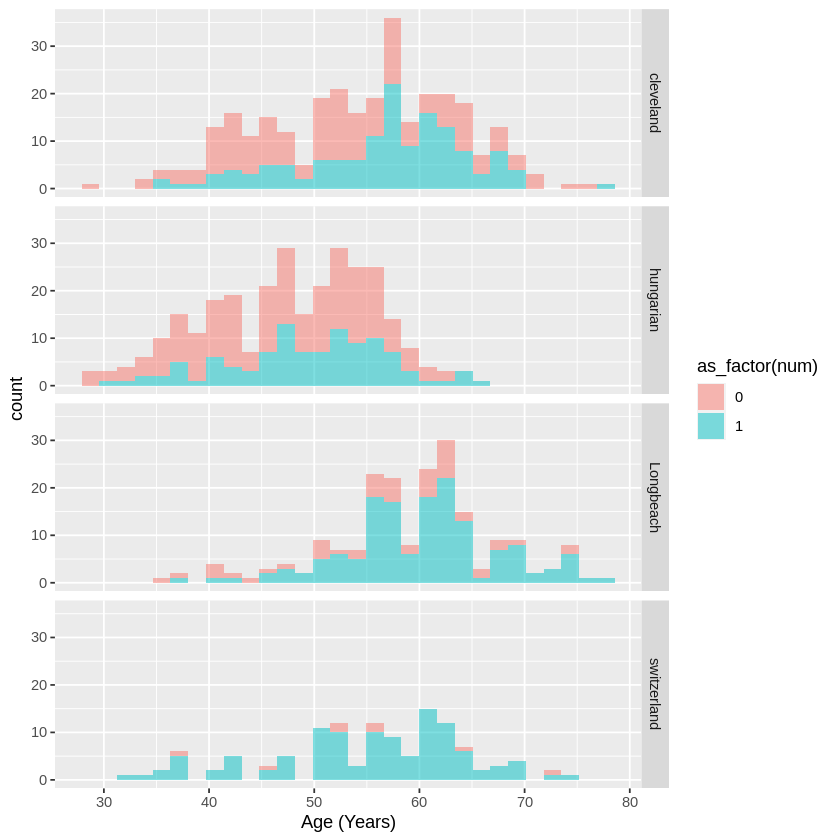

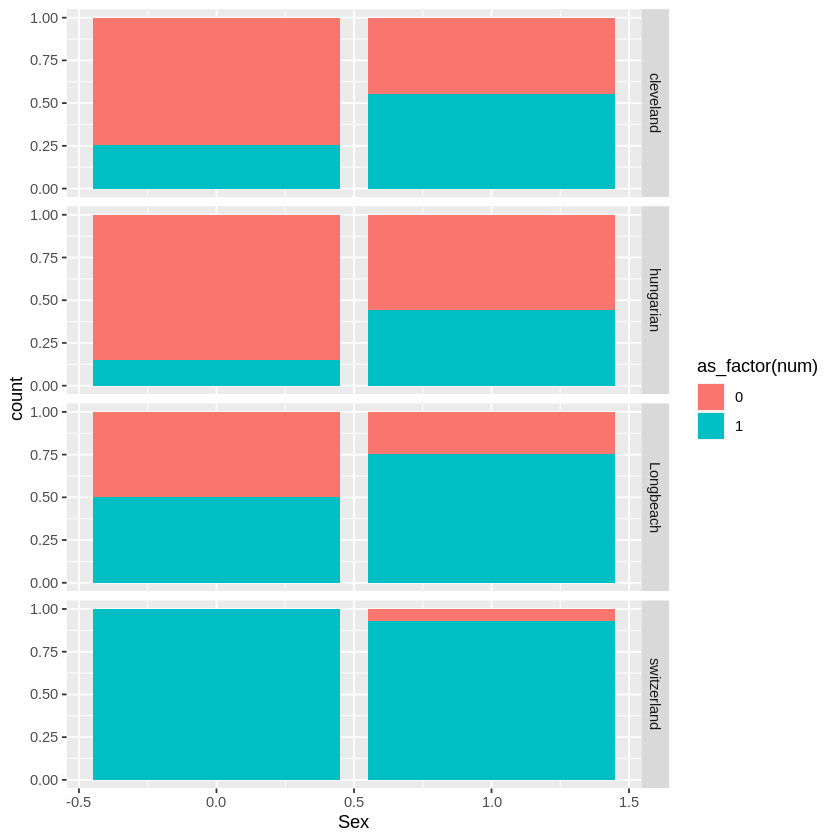

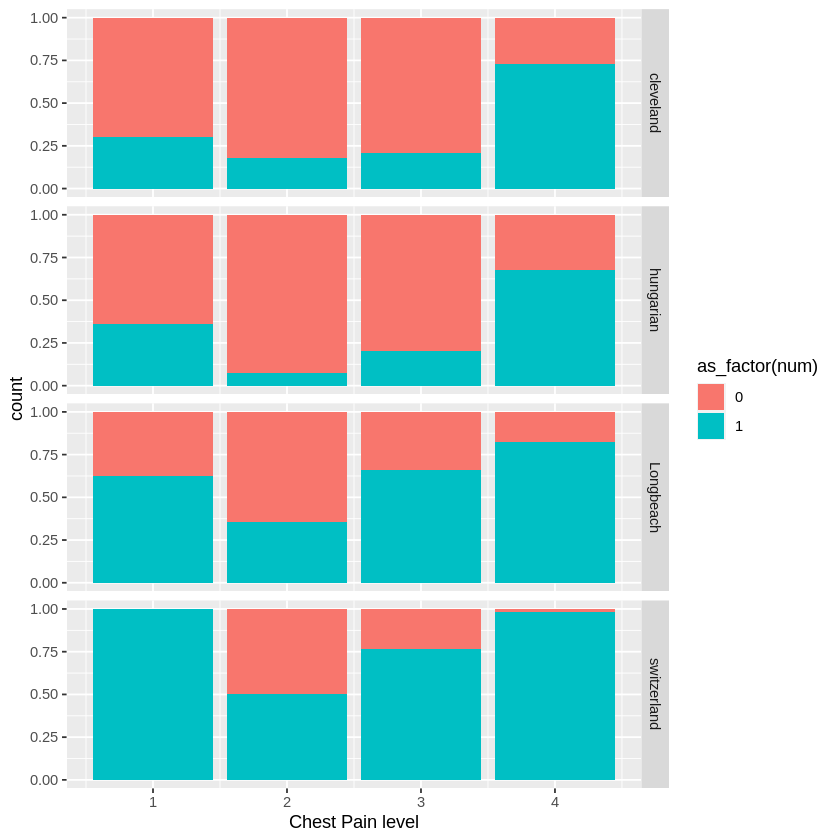

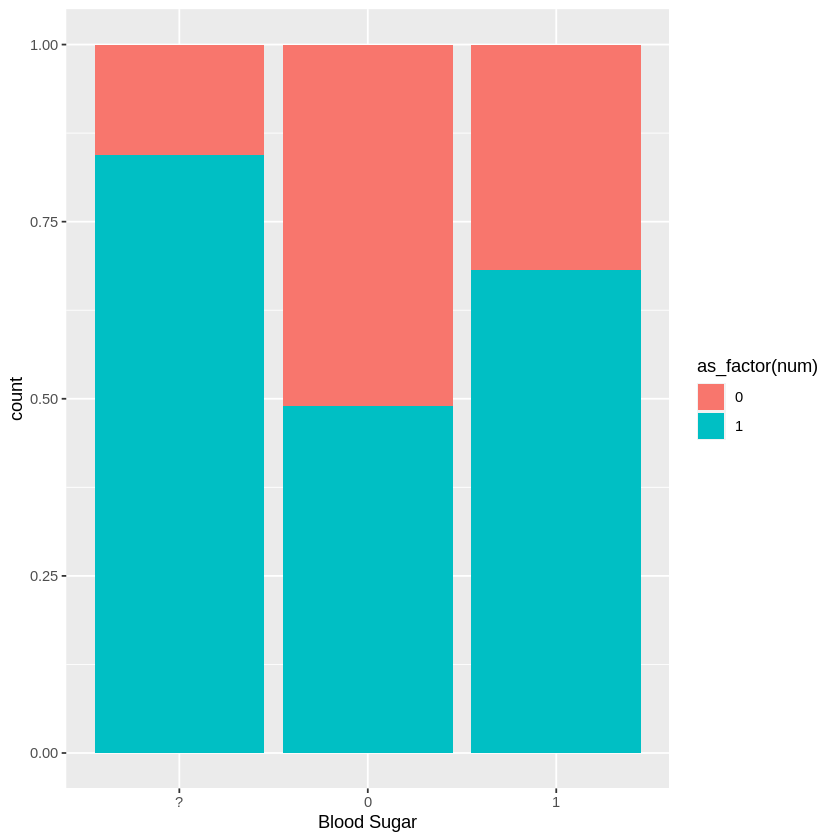

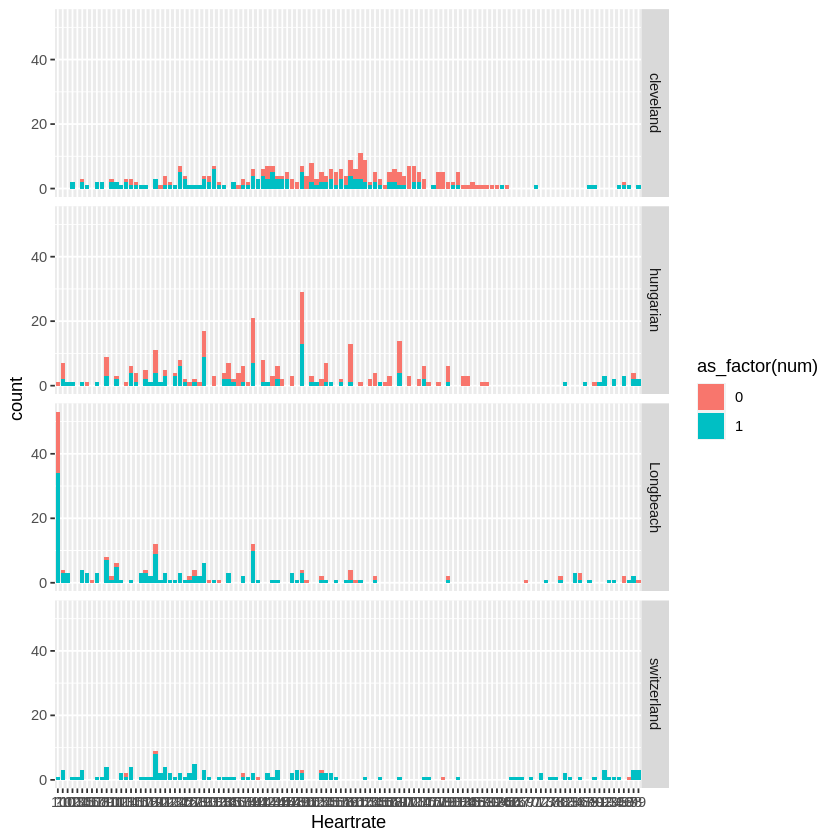

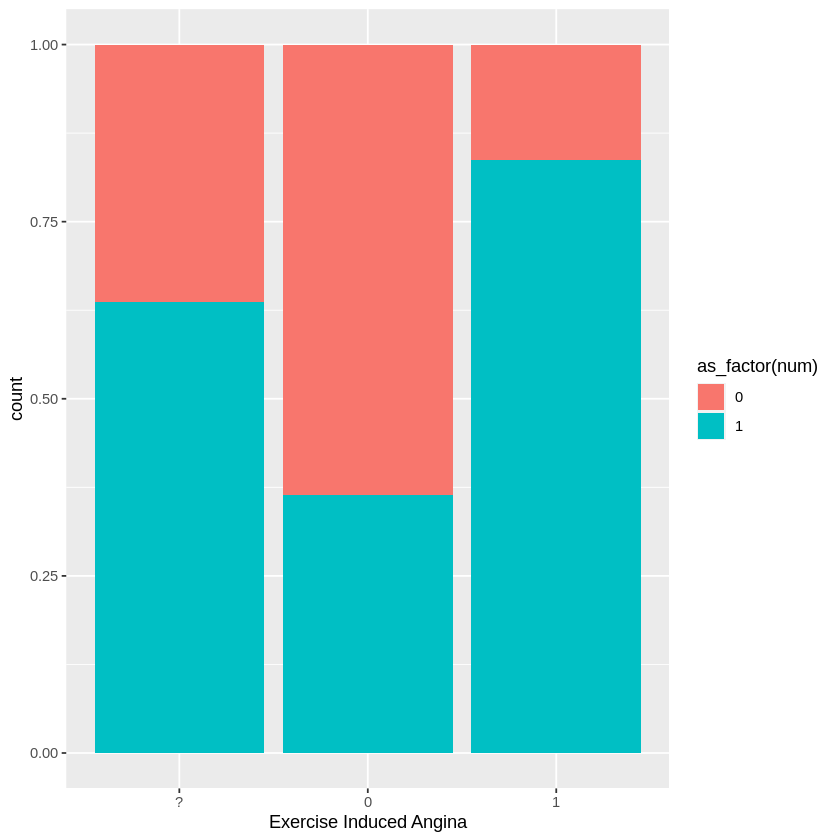

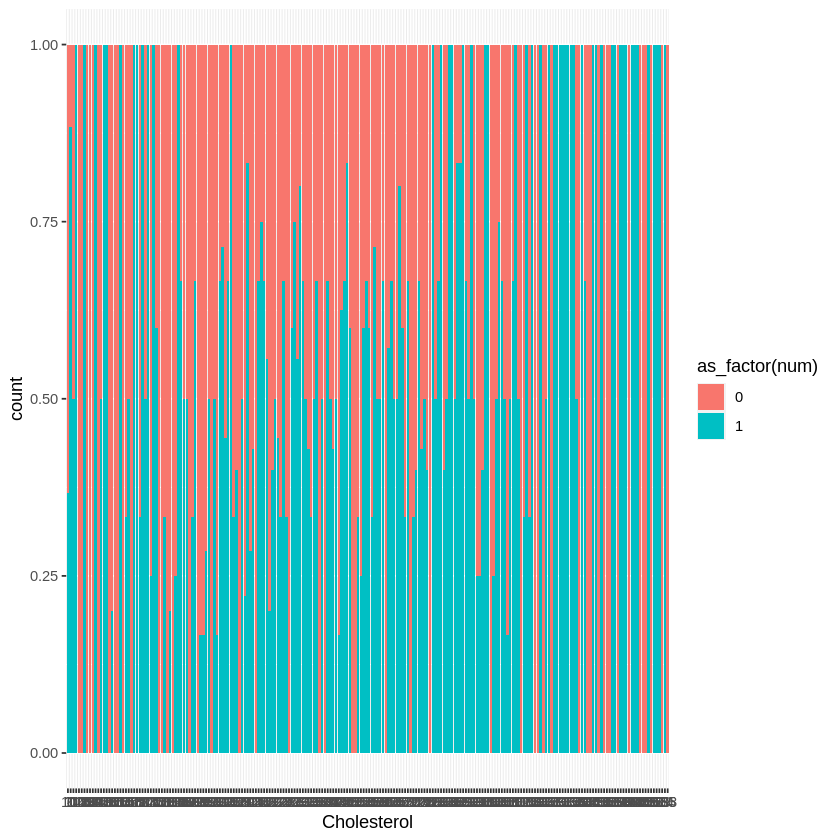

In [73]:
age_plot <- ggplot(heart_data_combined, aes(x = age)) +
    geom_histogram() +
    labs(x = "Age (Years)") +
    facet_grid(rows = vars(num))

age_plot2 <- ggplot(heart_data_combined, aes(x = age, fill = as_factor(num))) +
    geom_histogram(alpha = 0.5) +
    labs(x = "Age (Years)") +
    facet_grid(rows = vars(origin))
age_plot2

sex_plot <- ggplot(heart_data_combined, aes(x = sex, fill = as_factor(num))) +
    geom_bar(position = "fill") +
    labs(x = "Sex")+
    facet_grid(rows = vars(origin))
sex_plot

chest_plot <- ggplot(heart_data_combined, aes(x = cp, fill = as_factor(num))) +
    geom_bar(position = "fill") +
    labs(x = "Chest Pain level")+
    facet_grid(rows = vars(origin))
chest_plot

fbs_plot <- ggplot(heart_data_combined, aes(x = fbs, fill = as_factor(num))) +
    geom_bar(position = "fill") +
    labs(x = "Blood Sugar")
fbs_plot

thalach_plot <- ggplot(heart_data_combined, aes(x = thalach, fill = as_factor(num))) +
    geom_bar() +
    labs(x = "Heartrate")+
    facet_grid(rows = vars(origin))
thalach_plot

exang_plot <- ggplot(heart_data_combined, aes(x = exang, fill = as_factor(num))) +
    geom_bar(position = "fill") +
    labs(x = "Exercise Induced Angina")
exang_plot

chol_plot <- ggplot(heart_data_combined, aes(x = chol, fill = as_factor(num))) +
    geom_bar(position = "fill") +
    labs(x = "Cholesterol")
chol_plot

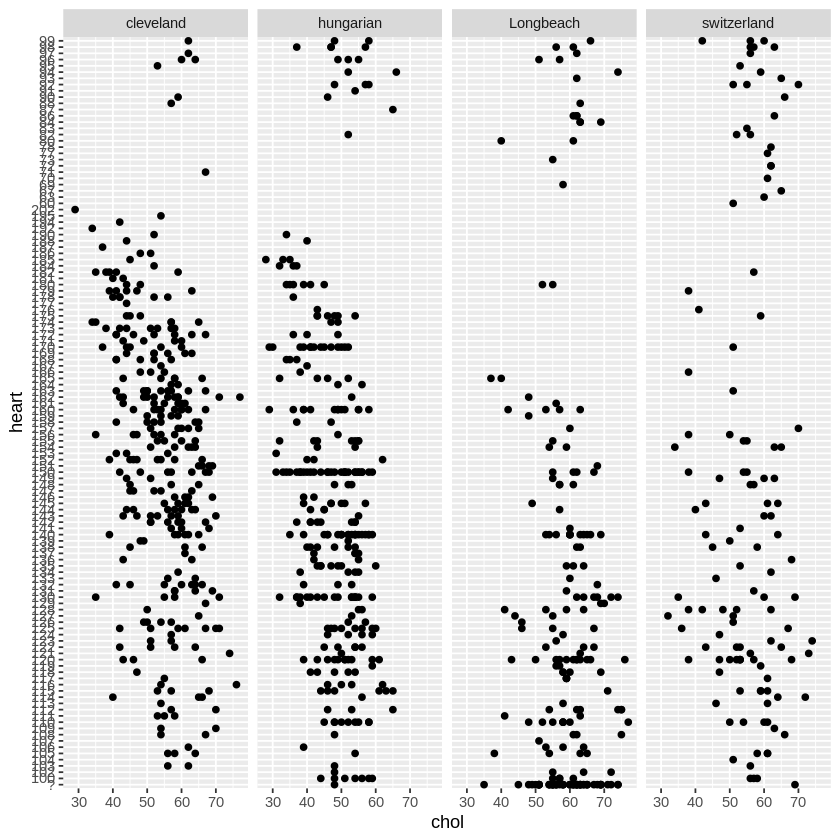

In [79]:
#Visualizations
chol_age <- ggplot(heart_data_combined, aes(x = age, y = thalach)) + geom_point() + labs(x = "chol", y = "heart")
chol_age



In [5]:
#Summarizing the presence of heart disease in the patient. 0 is no presence.
total_stats <-  heart_data |> group_by(num) |> count() |> rename("Severity_Level_of_HD" = num, "Total_Count" = n)
c_stats <- cleveland_data |> group_by(num) |> count() |> rename("Severity_Level_of_HD" = num, "C_Count" = n)
h_stats <- hungarian_data |> group_by(num) |> count() |> rename("Severity_Level_of_HD" = num, "H_Count" = n)
s_stats <- switzerland_data |> group_by(num) |> count() |> rename("Severity_Level_of_HD" = num, "S_Count" = n)
v_stats <- va_data |> group_by(num) |> count() |> rename("Severity_Level_of_HD" = num, "V_Count" = n)

#Here we notice that the hungarian data could skew our results as it only classified should we keep the 0-4 values in the diagnosis.
#total_stats
#c_stats
#h_stats
#s_stats
#v_stats

total_stats_combine <- total_stats |> filter(Severity_Level_of_HD != 0) |> mutate(Severity_Level_of_HD = 1) |> summarize(Total_Count = sum(Total_Count)) 
total_stats <- total_stats |> filter(Severity_Level_of_HD == 0) |> rbind(total_stats_combine)

c_stats_combine <- c_stats |> filter(Severity_Level_of_HD != 0) |> mutate(Severity_Level_of_HD = 1) |> summarize(C_Count = sum(C_Count)) 
c_stats <- c_stats |> filter(Severity_Level_of_HD == 0) |> rbind(c_stats_combine)

s_stats_combine <- s_stats |> filter(Severity_Level_of_HD != 0) |> mutate(Severity_Level_of_HD = 1) |> summarize(S_Count = sum(S_Count)) 
s_stats <- s_stats |> filter(Severity_Level_of_HD == 0) |> rbind(s_stats_combine)

v_stats_combine <- v_stats |> filter(Severity_Level_of_HD != 0) |> mutate(Severity_Level_of_HD = 1) |> summarize(V_Count = sum(V_Count)) 
v_stats <- v_stats |> filter(Severity_Level_of_HD == 0) |> rbind(v_stats_combine)

total_stats <- merge(total_stats, c_stats) |> merge(h_stats) |> merge(s_stats) |> merge(v_stats)
total_stats



Severity_Level_of_HD,Total_Count,C_Count,H_Count,S_Count,V_Count
<dbl>,<int>,<int>,<int>,<int>,<int>
0,411,164,188,8,51
1,509,139,106,115,149


### Expected Outcomes and Significance

